## MNIST training with the Keras Framework
-- adapted from Snelgrove's tutorial on Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


## Load training data

In [2]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


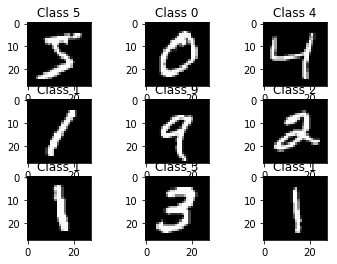

In [3]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## Prepare data for training
Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. We'll also scale the inputs to be in the range [0-1] rather than [0-255]

In [4]:
img_x, img_y = 28,28
X_train = X_train.reshape(60000, img_x*img_y)
X_test = X_test.reshape(10000, img_x*img_y)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


Modify the target matrices to be in the one-hot format, i.e.

0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.

In [5]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Build the network
First, a simple 3 layer fully connected network.
![network diagram](https://github.com/wxs/keras-mnist-tutorial/raw/8824b7b56963a92ef879f09acd99cf3a210db2b8/figure.png)

In [6]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.
                           
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.

## Compile the model
Keras is built on top of Theano (and now TensorFlow as well), both packages that allow you to define a computation graph in Python, which they then compile and run efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your loss function and your optimizer. The loss function we'll use here is called categorical crossentropy, and is a loss function well-suited to comparing two probability distributions.

Here our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. More detail at Wikipedia

The optimizer helps determine how quickly the model learns, how resistent it is to getting "stuck" or "blowing up". We won't discuss this in too much detail, but "adam" is often a good choice.

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

## Train the model!
This is the fun part: you can feed the training data loaded in earlier into this model and it will learn to classify digits.

In [8]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=10,
          verbose=1,validation_data=(X_test, Y_test),
          callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 40s 664us/step - loss: 0.2500 - acc: 0.9254 - val_loss: 0.1131 - val_acc: 0.9666
Epoch 2/10
60000/60000 [==============================] - 50s 828us/step - loss: 0.1001 - acc: 0.9697 - val_loss: 0.0813 - val_acc: 0.9741
Epoch 3/10
60000/60000 [==============================] - 46s 767us/step - loss: 0.0717 - acc: 0.9772 - val_loss: 0.0714 - val_acc: 0.9786
Epoch 4/10
60000/60000 [==============================] - 44s 728us/step - loss: 0.0563 - acc: 0.9817 - val_loss: 0.0718 - val_acc: 0.9774
Epoch 5/10
60000/60000 [==============================] - 43s 723us/step - loss: 0.0463 - acc: 0.9854 - val_loss: 0.0645 - val_acc: 0.9787
Epoch 6/10
60000/60000 [==============================] - 43s 719us/step - loss: 0.0390 - acc: 0.9870 - val_loss: 0.0658 - val_acc: 0.9814
Epoch 7/10
60000/60000 [==============================] - 45s 748us/step - loss: 0.0362 - acc: 0.9882 - val_loss: 0.

## Finally, evaluate its performance

Test loss: 0.06468466376215365
Test accuracy: 0.9813


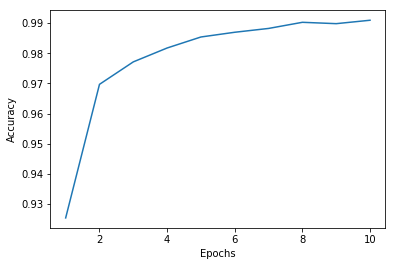

In [9]:
score = model.evaluate(X_test, Y_test,
                        verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


## Inspecting the output
It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.



In [10]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

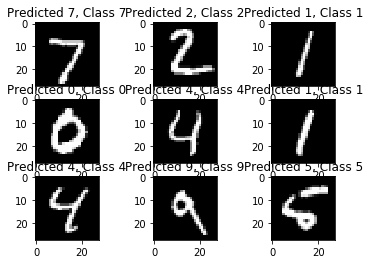

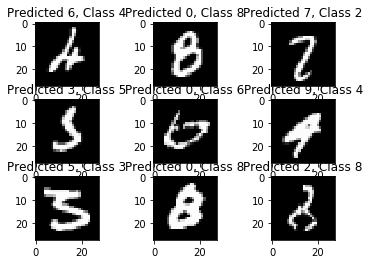

In [11]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## A CNN model

In [12]:
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D

Reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3

In [13]:
input_shape = (img_x, img_y, 1)
X_train = X_train.reshape(X_train.shape[0], img_x, img_y, 1)
X_test = X_test.reshape(X_test.shape[0], img_x, img_y, 1)

In [14]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_cnn.add(Conv2D(64, (5, 5), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(1000, activation='relu'))
model_cnn.add(Dense(nb_classes, activation='softmax'))

In [15]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



history_cnn = AccuracyHistory()

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 422s 7ms/step - loss: 0.1462 - acc: 0.9569 - val_loss: 0.0388 - val_acc: 0.9882
Epoch 2/10
60000/60000 [==============================] - 447s 7ms/step - loss: 0.0397 - acc: 0.9876 - val_loss: 0.0301 - val_acc: 0.9900
Epoch 3/10
60000/60000 [==============================] - 389s 6ms/step - loss: 0.0262 - acc: 0.9920 - val_loss: 0.0250 - val_acc: 0.9913
Epoch 4/10
60000/60000 [==============================] - 365s 6ms/step - loss: 0.0197 - acc: 0.9940 - val_loss: 0.0253 - val_acc: 0.9913
Epoch 5/10
60000/60000 [==============================] - 350s 6ms/step - loss: 0.0147 - acc: 0.9956 - val_loss: 0.0303 - val_acc: 0.9903
Epoch 6/10
60000/60000 [==============================] - 338s 6ms/step - loss: 0.0114 - acc: 0.9964 - val_loss: 0.0272 - val_acc: 0.9925
Epoch 7/10
60000/60000 [==============================] - 337s 6ms/step - loss: 0.0112 - acc: 0.9962 - val_loss: 0.0273 - 

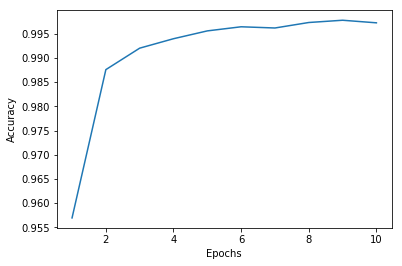

In [16]:
model_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history_cnn])

score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 11), history_cnn.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

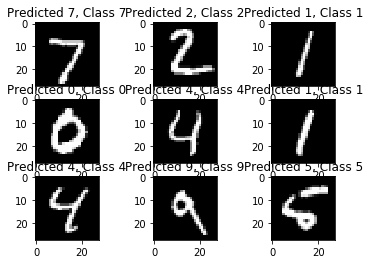

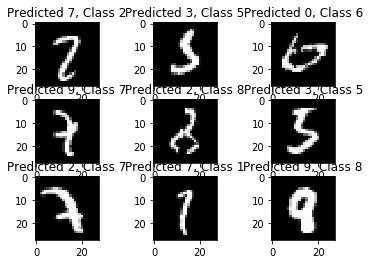

In [17]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model_cnn.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))